#### In this notebook we analyze the correlation of publisher bias and article bias

In [1]:
import xml.sax
import collections
import matplotlib.pyplot as plt
import numpy as np
from utils import fixedTestSplit

class GroundTruthHandler(xml.sax.ContentHandler):
    def __init__(self, label, sources, urls):
        xml.sax.ContentHandler.__init__(self)
        self.urls = urls
        self.label = label
        self.sources = sources

    def startElement(self, name, attrs):
        if name == "article":
            articleId = attrs.getValue("id")
            hyperpartisan = attrs.getValue("hyperpartisan")
            self.label.append(hyperpartisan)
            
            url = attrs.getValue("url")
            # parse url
            url = '/'.join(url.split('/')[:3])
            
            self.sources.append(url)
            if url in self.urls.keys():
                self.urls[url].append(hyperpartisan)
            else:
                self.urls[url] = [hyperpartisan]
                
                
def readFiles(labelFile):
    y, sources = [], []
    urls = {}
    with open(labelFile) as labelFile:
        xml.sax.parse(labelFile, GroundTruthHandler(y, sources, urls))
             
    return np.asarray(y), np.asarray(sources), urls
                
def count(label):
    return collections.Counter(label)

In [2]:
# manually check the leaning of the publisher through https://mediabiasfactcheck.com/
bias2Url = {
    'EL':['http://www.trueactivist.com',],
    'L':["https://www.salon.com", 'http://www.gq.com', 'https://www.rawstory.com', 'https://www.opednews.com', 'http://people.com'],
    'LC':['http://www.cbsnews.com', 'http://heavy.com', 'http://www.nytimes.com', 'http://www.rollingstone.com'],
    'C': ['http://www.snopes.com', 'http://www.nfl.com'],
    'RC':['http://nypost.com', 'https://www.realclearpolitics.com', 'https://www.circa.com'],
    'R':['https://pjmedia.com', 'http://www.express.co.uk','http://opslens.com','http://insider.foxnews.com', 'http://www.foxnews.com', 'http://www.washingtonexaminer.com', 'http://www.bizpacreview.com', 'https://bearingarms.com'],
    'ER':['http://www.thegatewaypundit.com',  "http://www.dcclothesline.com"]}

url2Bias = {}
for i,j in bias2Url.items():
    for url in j:
        url2Bias[url] = i 

In [3]:
# set path for data
dataPath = 'data/'
labelFile = dataPath + "ground-truth-training-byarticle.xml"

labels, sources, urls = readFiles(labelFile)
id1, id2 = fixedTestSplit(labels)

In [4]:
aggr = collections.OrderedDict()
for bias in bias2Url.keys():
    bias_total = 0
    bias_percent = 0
    print("="*20 + bias + "="*20)
    for url in bias2Url[bias]:
        if url in urls.keys():
            biased = count(urls[url])['true']
            unbiased = count(urls[url])['false']
            total = biased + unbiased
            percent = 100* biased / total
            print("%s: %0.2f (%i/%i)" %(url, percent, biased, total))
            bias_total += total
            bias_percent += biased
            
    aggr[bias] = bias_percent / bias_total

====================EL====================
http://www.trueactivist.com: 62.50 (5/8)
====================L====================
https://www.salon.com: 100.00 (8/8)
http://www.gq.com: 60.00 (3/5)
https://www.rawstory.com: 40.00 (2/5)
https://www.opednews.com: 100.00 (7/7)
http://people.com: 20.00 (1/5)
====================LC====================
http://www.cbsnews.com: 11.11 (3/27)
http://heavy.com: 7.69 (1/13)
http://www.nytimes.com: 30.00 (3/10)
http://www.rollingstone.com: 75.00 (3/4)
====================C====================
http://www.snopes.com: 8.33 (1/12)
http://www.nfl.com: 0.00 (0/8)
====================RC====================
http://nypost.com: 66.67 (10/15)
https://www.realclearpolitics.com: 92.86 (13/14)
https://www.circa.com: 12.50 (3/24)
====================R====================
https://pjmedia.com: 100.00 (6/6)
http://www.express.co.uk: 36.84 (7/19)
http://opslens.com: 100.00 (14/14)
http://insider.foxnews.com: 27.27 (3/11)
http://www.foxnews.com: 50.00 (3/6)
http://www.wash

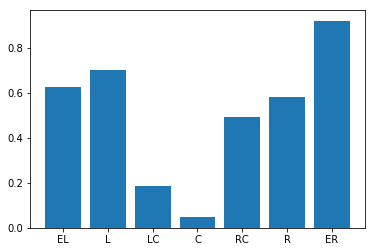

In [6]:
plt.bar(range(7), aggr.values(), tick_label=aggr.keys())
#plt.title("Percentage of hyperpartisan articles by publisher bias")
plt.show()

### Error analysis

In [10]:
def errorAnalysis(gt, pred, sources):
    
    bias2Url = {
    'EL':['http://www.trueactivist.com',],
    'L':["https://www.salon.com", 'http://www.gq.com', 'https://www.rawstory.com', 'https://www.opednews.com', 'http://people.com'],
    'LC':['http://www.cbsnews.com', 'http://heavy.com', 'http://www.nytimes.com', 'http://www.rollingstone.com'],
    'C': ['http://www.snopes.com', 'http://www.nfl.com'],
    'RC':['http://nypost.com', 'https://www.realclearpolitics.com', 'https://www.circa.com'],
    'R':['https://pjmedia.com', 'http://www.express.co.uk','http://opslens.com','http://insider.foxnews.com', 'http://www.foxnews.com', 'http://www.washingtonexaminer.com', 'http://www.bizpacreview.com', 'https://bearingarms.com'],
    'ER':['http://www.thegatewaypundit.com',  "http://www.dcclothesline.com"]}

    url2Bias = {}
    for i,j in bias2Url.items():
        for url in j:
            url2Bias[url] = i 
            
    dct = {} 
    dct['center'] = []
    dct['biased'] = []
    for i, s in enumerate(sources):
        if s not in url2Bias.keys():
            continue
        if url2Bias[s] in ['RC', 'C', 'LC']:
            sou = 'center' 
        else:
            sou = 'biased'
        dct[sou].append((gt[i], pred[i]))
    
    
    # FP and FN
    b = []
    counts = []
    t = []
    fnIdx = np.intersect1d(np.where(gt == 'true')[0], (np.where(pred == 'false')[0]))
    fpIdx = np.intersect1d(np.where(gt == 'false')[0], (np.where(pred == 'true')[0]))
    error = collections.Counter([url2Bias[s] for s in sources[np.concatenate((fnIdx, fpIdx))] if s in url2Bias.keys()])
    total = collections.Counter([url2Bias[s] for s in sources if s in url2Bias.keys()])
    for bias in bias2Url.keys():
        b.append(bias)
        counts.append(error[bias]/total[bias])
        t.append(total[bias])
    return b, counts, dct

In [11]:
tfidf_pred = np.load("predictions/tfidf_svm_pred.npy")
glove_pred = np.load("predictions/glove_svm_pred.npy")
doc2vec_pred = np.load("predictions/doc2vec_svm_pred.npy")

In [12]:
b1, count1, dct1= errorAnalysis(labels[id2], tfidf_pred, sources[id2])
b2, count2, dct2= errorAnalysis(labels[id2], glove_pred, sources[id2])
b3, count3, dct3= errorAnalysis(labels[id2], doc2vec_pred, sources[id2])

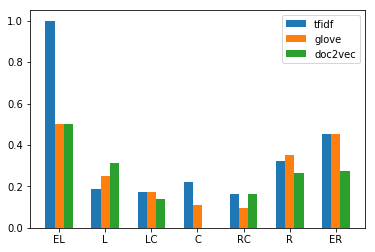

In [13]:
x1 = np.array(range(7))-0.2
x2 = np.array(range(7))
x3 = np.array(range(7))+0.2
plt.bar(x1, count1, width = 0.2)
plt.bar(x2, count2, width = 0.2, tick_label=b1)
plt.bar(x3, count3, width = 0.2)
plt.legend(['tfidf', 'glove', 'doc2vec'])
plt.show()